### MIRI MNIST dataset

In [63]:
import sys
import os
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
from src.imputer_wrapper import impute_now
import argparse
import torch.nn as nn
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt

def plot_imgs(X, title):
    print(title)
    
    fig, axes = plt.subplots(10, 10, figsize=(5.7, 5.7))
    for i in range(10):
        for j in range(10):
            if X.shape[1] == 3072:
                axes[i, j].imshow(X[i * 10 + j, :].reshape(3, 32, 32).permute(1, 2, 0).cpu(), interpolation='none')
            else:
                axes[i, j].imshow(X[i * 10 + j, :].reshape(32, 32).cpu(), interpolation='none', cmap='gray')
            axes[i, j].axis('off')
    plt.subplots_adjust(wspace=-.01, hspace=-.01)
    plt.show()
    

### Generating Dataset

methods:  ['miri', 'gain_image']
Data size n:  5000 d:  3072 p:  0.4
Missing rate:  0.5998768210411072
Groud truth


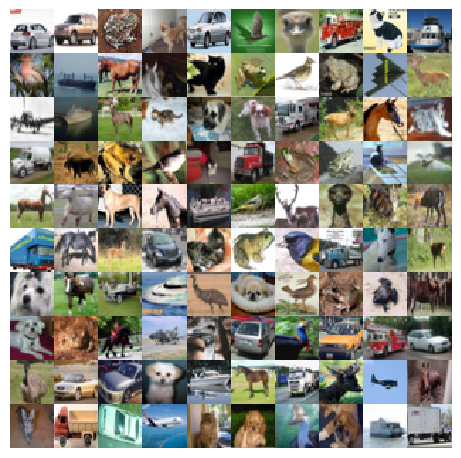

corrupted data (missing components replaced by rand values)


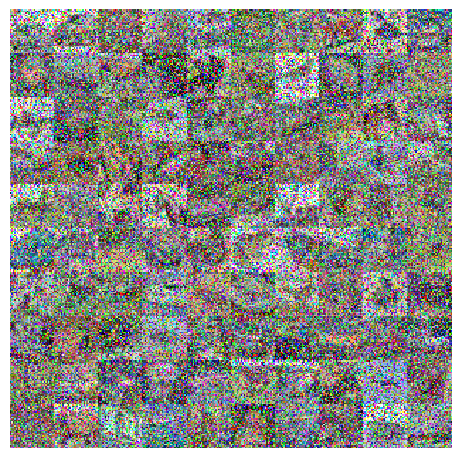

------------ The tests begins now ------------ 
 


In [64]:
import zipfile

dset = 'cifar' # mnist or cifar.
p = 0.4
seed = 1

torch.manual_seed(seed)

methods = ['miri', 'gain_image'] 
print("methods: ", methods)
with zipfile.ZipFile(f'./data/{dset}.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
Xdata = torch.load(f"./data/{dset}.pt", map_location='cpu').to(device)
n = 5000 # use small number of the dataset for shorter runtime
d = Xdata.shape[1]
def sample_ref(n):
    X = Xdata[:n, :].detach().clone()
    Xstar = X.detach().clone()
    
    M = torch.distributions.bernoulli.Bernoulli(torch.ones(n, d)*p).sample().to(device)
    X[M==0] = torch.rand(n, d).to(device)[M==0] # missing independently across all channels
    
    return X.cpu(), M.cpu(), Xstar.cpu()

X0, M, Xstar = sample_ref(n)
print("Data size", "n: ", X0.shape[0], "d: ", X0.shape[1], "p: ", p)
print("Missing rate: ", 1 - M.mean().item())

plot_imgs(Xstar, "Groud truth")
plot_imgs(X0, "corrupted data (missing components replaced by rand values)")

print("------------ The tests begins now ------------ \n ")

### Running Imputation Methods

In [ ]:
for method in methods:
    X_tilde, mmd_list, mi_list = impute_now(X0, M, Xstar, method, max_rounds=15, batchsize=500, maxepochs=900)
    torch.save([X_tilde, mmd_list, mi_list], f"res/{dset}_{seed}_{method}.pt")


### Printing Results

Imputed data by miri


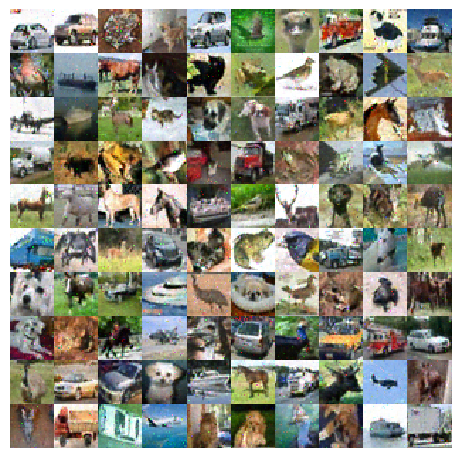

Imputed data by gain_image


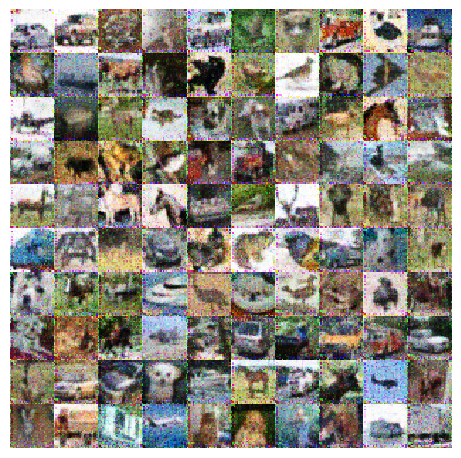

Imputation Results Summary of cifar dataset with seed 1 and p=0.4
       method  mmd (the smaller the better)  mi (the smaller the better)
0        miri                      0.000121                    -2.058446
1  gain_image                      0.018376                    -1.599376


In [66]:
import pandas as pd


results = []
for method in methods:
    X_tilde, mmd_list, mi_list = torch.load(f"res/{dset}_{seed}_{method}.pt")
    results.append({
        "method": method,
        "mmd (the smaller the better)": float(mmd_list[-1]),
        "mi (the smaller the better)": float(mi_list[-1])
    })
    
    plot_imgs(X_tilde, f"Imputed data by {method}")

df_results = pd.DataFrame(results)
print(f"Imputation Results Summary of {dset} dataset with seed {seed} and p={p}")
print(df_results)
    